In [139]:
import numpy as np
import matplotlib.pyplot as plt

In [140]:
# 载入数据
def loadDataSet(fileName):
    dataMat =[]
    labelMat = []
    with open(fileName) as fr:
        for line in fr.readlines():
            lineArr = line.strip().split('\t')
            dataMat.append([float(lineArr[0]),float(lineArr[1])])
            labelMat.append(float(lineArr[2]))
    return dataMat,labelMat

In [141]:
dataArr,labelArr = loadDataSet('./testSet.txt')

In [142]:
# 全局数据存贮对象
class optStruct:
    def __init__(self,dataMatIn,classLabels,C,toler):
        self.X = dataMatIn
        self.labelMat = classLabels
        self.C = C
        self.tol = toler
        self.m = np.shape(dataMatIn)[0]
        self.alphas = np.mat(np.zeros((self.m,1)))
        self.b = 0
        self.eCache = np.mat(np.zeros((self.m,2))) # [1,Ek] 第一位是使能标志位，第二位是Ek值

In [143]:
# 计算误差值
def calcEk(oS,k):
    fXk = float(np.multiply(oS.alphas,oS.labelMat).T*(oS.X*oS.X[k,:].T)) + oS.b
    Ek = fXk - float(oS.labelMat[k])
    return Ek

In [144]:
# 从剩余alpha索引中随机选择一个
# i aplha下标
# m 所有alpha的数目
def selectJrand(i,m):
    j = i 
    while(j == i): # 保证从剩余中选取
        j = int(np.random.uniform(1,m))
    return j

In [145]:
#  调整大于H或小于L的aplha值
def clipAlpha(aj,H,L):
    if aj > H:
        aj = H
    elif aj < L:
        aj = L
    return aj

In [146]:
# 启发式选取内层循环的j索引
def selectJ(i,oS,Ei):
    maxK = -1
    maxDeltaE = 0
    Ej = 0
    oS.eCache[i] = [1,Ei]
    validEcacheList = np.nonzero(oS.eCache[:,0].A)[0] # 已计算过E值的j索引
    if len(validEcacheList) > 1:
        for k in validEcacheList:
            if k == i :
                continue
            Ek = calcEk(oS,k) # 重新计算
            deltaE = abs(Ei-Ek) # 选取E最大值对应的j
            if deltaE > maxDeltaE:
                maxK = k
                maxDeltaE = deltaE
                Ej = Ek
        return maxK,Ej
    else:
        j = selectJrand(i,oS.m) # 第一次寻找，随机寻找
        Ej = calcEk(oS,j)
    return j,Ej

In [147]:
# alpha值优化后需要存储Ek
def updateEk(oS,k):
    Ek = calcEk(oS,k)
    oS.eCache[k] = [1,Ek]

In [148]:
def innerL(i,oS):
    Ei = calcEk(oS,i)
    if ((oS.labelMat[i]*Ei < -oS.tol) and (oS.alphas[i] <oS.C)) or ((oS.labelMat[i]*Ei > oS.tol)and(oS.alphas[i] >0)):
        j,Ej = selectJ(i,oS,Ei)
        alphaIold = oS.alphas[i].copy()
        alphaJold = oS.alphas[j].copy()
        if (oS.labelMat[i] != oS.labelMat[j]):
            L = max(0,oS.alphas[j] - oS.alphas[i])
            H = min(oS.C,oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            L = max(0,oS.alphas[j] + oS.alphas[i] -oS.C)
            H = min(oS.C,oS.alphas[j] + oS.alphas[i])
        if L==H:print("L==H");return 0
        eta = 2.0 *  oS.X[i,:]*oS.X[j,:].T - oS.X[i,:]*oS.X[i,:].T - oS.X[j,:]*oS.X[j,:].T
        if eta >=0: print('eta >= 0 ');return 0
        oS.alphas[j] -= oS.labelMat[j]*(Ei - Ej)/eta
        oS.alphas[j] = clipAlpha(oS.alphas[j],H,L)
        updateEk(oS,j)
        if abs(oS.alphas[j] - alphaJold) < 0.00001:
            print('j not moving enough')
            return 0
        oS.alphas[i] += oS.labelMat[j]*oS.labelMat[i]*(alphaJold - oS.alphas[j])
        updateEk(oS,i)
        b1 = oS.b - Ei - oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.X[i,:]*oS.X[i,:].T  - oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.X[i,:]*oS.X[j,:].T
        b2 = oS.b - Ej - oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.X[i,:]*oS.X[j,:].T  - oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.X[j,:]*oS.X[j,:].T
        if  (0<alphas[i]) and (oS.C > alphas[i]):
            oS.b = b1
        elif (0<alphas[j]) and (oS.C > alphas[j]):
            oS.b = b2
        else:
            oS.b = (b1+b2)/2.0
        return 1
    else:
        return 0

In [160]:
def smoP(dataMatIn,classLabels,C,toler,maxIter):
    oS = optStruct(np.mat(dataMatIn),np.mat(classLabels).transpose(),C,toler)
    iterNum = 0
    entireSet = True
    alphaPairsChanged = 0
    while(iterNum<maxIter) and ((alphaPairsChanged >0)or entireSet):
        alphaPairsChanged = 0
        if entireSet:
            for i in range(oS.m):
                alphaPairsChanged += innerL(i,oS)
                print('fullset, iterNUm: %d i: %d, pairs changed %d'%(iterNum,i,alphaPairsChanged))
            iterNum += 1
        else:
            nonBoundIs = np.nonzero((oS.alphas.A >0)*(oS.alphas.A<C))[0]
            for i in nonBoundIs:
                alphaPairsChanged += innerL(i,oS)
                print("non-bound, iterNum:%d i:%d, pairs changed %d"%(iterNum,i,alphaPairsChanged))
            iterNum += 1
        if entireSet:
            entireSet = False
        elif alphaPairsChanged == 0:
            entireSet = True
        print('iteration number: %d'%iterNum)
    return oS.b,oS.alphas
            
                      

In [161]:
b,alphas = smoP(dataArr,labelArr,0.6,0.001,40)

fullset, iterNUm: 0 i: 0, pairs changed 1
fullset, iterNUm: 0 i: 1, pairs changed 1
fullset, iterNUm: 0 i: 2, pairs changed 1
fullset, iterNUm: 0 i: 3, pairs changed 2
fullset, iterNUm: 0 i: 4, pairs changed 3
fullset, iterNUm: 0 i: 5, pairs changed 4
fullset, iterNUm: 0 i: 6, pairs changed 4
fullset, iterNUm: 0 i: 7, pairs changed 4
fullset, iterNUm: 0 i: 8, pairs changed 5
fullset, iterNUm: 0 i: 9, pairs changed 5
L==H
fullset, iterNUm: 0 i: 10, pairs changed 5
fullset, iterNUm: 0 i: 11, pairs changed 5
fullset, iterNUm: 0 i: 12, pairs changed 5
fullset, iterNUm: 0 i: 13, pairs changed 5
fullset, iterNUm: 0 i: 14, pairs changed 5
fullset, iterNUm: 0 i: 15, pairs changed 5
fullset, iterNUm: 0 i: 16, pairs changed 5
L==H
fullset, iterNUm: 0 i: 17, pairs changed 5
fullset, iterNUm: 0 i: 18, pairs changed 5
fullset, iterNUm: 0 i: 19, pairs changed 5
fullset, iterNUm: 0 i: 20, pairs changed 5
fullset, iterNUm: 0 i: 21, pairs changed 5
fullset, iterNUm: 0 i: 22, pairs changed 5
L==H
fullse

In [162]:
b

matrix([[-2.98556122]])

In [163]:
alphas[alphas>0]

matrix([[ 0.04198096,  0.00684597,  0.12069328,  0.02633854,  0.02633854,
          0.01876918,  0.19287213,  0.05581304]])

In [164]:
for i in range(100):
    if alphas[i] > 0.0:
        print(str(dataArr[i])+str(labelArr[i]))

[3.542485, 1.977398]-1.0
[8.127113, 1.274372]1.0
[3.634009, 1.730537]-1.0
[3.223038, -0.552392]-1.0
[7.286357, 0.251077]1.0
[5.286862, -2.358286]1.0
[6.080573, 0.418886]1.0
[3.107511, 0.758367]-1.0


In [165]:
def clacWs(alphas,dataArr,labelArr):
    dataMat = np.mat(dataArr)
    labelMat = np.mat(labelArr).transpose()
    m,n= np.shape(dataArr)
    weights = np.zeros((n,1))
    for i in range(m):
        weights += np.multiply(alphas[i]*labelMat[i],dataMat[i,:].T)
    return weights

In [166]:
weights = clacWs(alphas,dataArr,labelArr)

In [167]:
def classify(weights,b,dataArr):
    dataMat = np.mat(dataArr)
    return dataMat[0]*weights+b

In [169]:
classify(weights,b,[3.542485,1.977398])

matrix([[-1.12778527]])

In [181]:
# plot with matplotlib
def plotBestFit(alphas,b,dataArr,labelArr):
    dataMat = np.mat(dataArr)
    labelMat = np.mat(labelArr).transpose()
    m,n= np.shape(dataArr)
    # 绘制两类数据点
    xcord1 = []
    xcord2 = []
    ycord1 = []
    ycord2 = []
    for i in range(m):
        if int(labelMat[i,0]) == 1.0:
            xcord1.append(dataMat[i,0])
            ycord1.append(dataMat[i,1])
        else:
            xcord2.append(dataMat[i,0])
            ycord2.append(dataMat[i,1])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(xcord1,ycord1,s= 30,c = 'red',marker = 's')
    ax.scatter(xcord2,ycord2,s= 30,c = 'blue')
    # 绘制支持向量
    spVector = np.array([[dataMat[i,0],dataMat[i,1]] for i in range(m) if alphas[i] > 0.0])
#     print(spVector)
    ax.scatter(spVector[:,0],spVector[:,1],s= 30,c = 'yellow')
    # 绘制决策边界
    x1 = np.arange(-1.0,10.0,0.1)
    weights = np.zeros((n,1))
    for i in range(m):
        weights += np.multiply(alphas[i]*labelMat[i],dataMat[i,:].T)
    x2 = -(b+ weights[0]*x1)/weights[1] # 0 = w0*x0 + w1*x1 + w2*x2
    ax.plot(x1,x2.getA1()) # 注意这里的维度问题 mat对象即使扁平化也是1*n维度的，getA1() 获得一个数组
    plt.xlabel("X1")
    plt.ylabel('X2')
    plt.show()

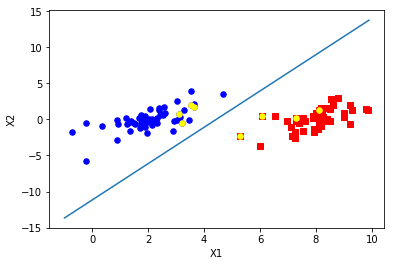

In [183]:
plotBestFit(alphas,b,dataArr,labelArr)